# Automatic sleep stage classification with CNN and LSTM   


## Threshold Analysis 

This is the third of 3 notebooks for Automatic sleep stage classification with CNN and LSTM.

The general purpose of the 3 notebooks is to extract data from Sleep EDF database and perform sleep classification with CNN and LSTM techniques. In this notebook specifically, a quick threshold analysis is performed to test if the general accuracy of the model can be improved by sending only the necessary sleep epochs to manual review.

For best reproducibility effects, I recommend to run all code in a Google Colab environment with an active GPU hardware accelerator.

This third notebook has the next sections:
* I. Libraries and data load
* II. Threshold values 


# I. Libraries and data load

In [1]:
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd
import seaborn as sns
import numpy as np

from google.colab import drive 
drive.mount('/content/gdrive')

path = '/content/gdrive/My Drive/Automatic_sleep_classification/results/cnnconcat.pkl' #fill with own path

with open(path, 'rb') as f:
    data = pickle.load(f)



Mounted at /content/gdrive


In [2]:
y_scores = []
y_preds = []
y_trues = []
for i in data:
  y_scores.extend(i['y_prob'])
  y_preds.extend(i['y_pred'])
  y_trues.extend(i['y_test'])

# II. Threshold Analysis

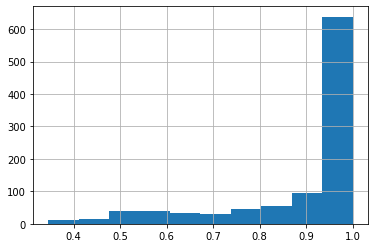

In [3]:
# First, lets see the probabilities produces by the classifier

scores = pd.Series(y_scores)
scores = scores.apply(lambda x: max(x))
scores.sample(n=1000).hist()


### NOTE

As we can see, not all predictions were obtained with a y_score or probability of 1.0 (total confidence). This means that the model had a higher or lower confidence in the prediction depending on the data fed to the network. Therefore, a threshold can be set to separate the "confident" predictions from the less confident ones, which have a higher chance of being incorrect. 

The proposal is that these weaker predictions should receive an in-depth analysis from a human scorer.

In [4]:
len(scores)

42308

In [5]:
# Prepare the dataframe

df = pd.DataFrame({'predicted':y_preds, 'true':y_trues, 'probs':scores })

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


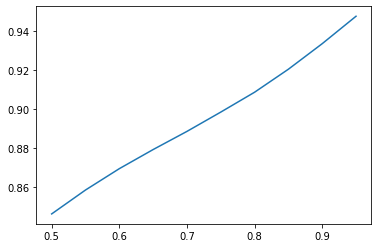

In [6]:
import seaborn as sns 
from sklearn.metrics import accuracy_score

%matplotlib inline

# We analyze the relationship between threshold values (TV) and accuracy of the remaining data points (sleep epochs)

acc_scores = []
ths = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for i in ths:
  dff = df[df.probs > i].reset_index()
  acc = accuracy_score(dff.true, dff.predicted)
  #print(acc)
  acc_scores.append(acc)

sns.lineplot(ths, acc_scores)

### NOTE
Constant linear relationship between Tresh Value and accuracy. The accuracy goes up as the TV rises: each time we are measuring accuracy with predictions where the model is more certain, so it makes sense that this score increases.

By defining TV that filter out the 5, 10 or 20% less confident predictions, to mention some options, we can guarantee that the remaining sleep epochs will pertain to a more accurate group of predictions. These filtered epochs should be the ones in which doctors should focus their time and energy to correctly annotate. By reducing in almost 80% the amount of epochs that need to be annotated, doctors can allocate their time in even more valuable activities.

In [7]:

o_size = df.shape[0]

th = np.percentile(df.probs,20)  # change the percentile parameter to set percentage of epochs to filter out (5, 10, 20)
print('The threshold value is: ' + str(th)[0:5]+ '\n')
dff = df[df.probs > th].reset_index()
left = df[df.probs <= th].reset_index()

new_size = dff.shape[0]

print( str((o_size - new_size)) + ' sleep epochs were filtered out or discarded (sent to manual review). \n')

print('The resulting classification report is: \n \n', classification_report(dff.true, dff.predicted, digits=4))

The threshold value is: 0.762

8462 sleep epochs were filtered out or discarded (sent to manual review). 

The resulting classification report is: 
 
               precision    recall  f1-score   support

           0     0.9048    0.9690    0.9358      7000
           1     0.5953    0.1522    0.2425      1005
           2     0.9451    0.8865    0.9149     14453
           3     0.9303    0.9423    0.9362      4729
           4     0.8133    0.9459    0.8746      6659

    accuracy                         0.9013     33846
   macro avg     0.8378    0.7792    0.7808     33846
weighted avg     0.8984    0.9013    0.8943     33846



As it has been shown, adding Threshold value to the activity of sleep classification enables the opportunity of assigning to manual review only the necessary sleep epochs, while quickly processing the rest of the easier epochs with an automatic clasifier and even raising the overall accuracy of the solution. 